Using recipe ingredients to categorize the cuisine

Different countries and regions have different cooking habits and corresponding recipes. So Our task is to build a classifier to determine the cuisine of a recipe based on its ingredients. The reason why we attach great importance to this task is that this classifier can serve as important reference for customers who go to unfamiliar restaurant and order unfamiliar food. Moreover, such task can cultivate our abilities to apply different machine learning algorithms into specific real world problems and of course, to use effective data-preprocessing techniques to deal with the raw data.

We finish this project in following steps.

#Data preprocessing

We obtain the original data from kaggle. They provide 39774 training samples and 9944 test samples. Each training sample comes with a unique id, a “cuisine” label referring its category and several ingredients. Basically, cuisine is our training target and ingredients are our inputs.

#Feature Engineering

We build the bag of words which is used to count the frequency of the occurrence of each ingredients and we build the ingredients dictionary which regards each ingredient as a vector and represents the occurrence by 0/1 code with the use of one-hot encoding.
The result of the word bags is nearly 6000 ingredients and the occurrence frequency is ranging from 1 to 18000. The result of the ingredients Vector is nearly 6000 features and 40000 records. The attribute value of each feature is 0/1 code. We also applied TF*IDF Method to deal with our dataset, and trained it on SVM model.

#Model Training

We applied different algorithms including decision tree, random forest, logistic regression (L1 & L2), SVM and KNN, adjusted the parameters of each algorithm, and tried different methods to reduce dimension and get corresponding accuracy(We submitted our test result to get corresponding accuracy from Kaggle.)
For the decision tree and Random Forest, we obtained the accuracy of 62.1% and 73.1% on the testing set. By calculating the information gain, we got the features’ importance list which is an important reference for the later re-processing data.
For the logistic regression, we used one versus rest logistic regression to build one regression model for each cuisine, in order to observe weights and display correlated ingredients for each cuisine. Both L1 and L2 version logistic regression are tried and the accuracy on testing set are both around 78%, while l2 version performs slightly better. So we choose L2 penalty and 1.2 penalty weight. We also use parameters of logistic regression to show each ingredient importance for each cuisine.
For the SVM, we chose One-or-Rest support vector classifier method to train the model. To determine the weight of ingredients, we chose the term frequency–inverse document frequency (TF*IDF) method, fully considering the functions of term frequency, term count, and inverse document frequency. Eventually we got 81% accuracy on the testing set.
For the KNN, by calculating the distance based on the ingredients vector, we can determine the cuisine according to its nearest neighbor. The accuracy is around 59% on the testing set.

#Reduce Dimension & Ensemble Models

At first, we tried to use top frequency feature dimension reduction strategy. After our tests on dataset, we found out that reducing the whole dataset to the top 3000 features can largely reduce computation complexity with slightly loss of accuracy.
Then, since there are some ingredients which can be seen as parents and children. (e.g. “tomato” and “green tomato”), we did some text processing work, trying to include all children situation to their parents. So we got another data set without the parent-children structure. We re-trained our model using the data which has eliminated the parent-children structure and deciding which data set to use based on the test accuracy.
What’s more, we also tried PCA dimension reduction strategy to reduce dimension, and retrained our model to identify whether we need to use dimension reduction technique. The detailed output are shown on the following table. We can see that based on our dataset, neither PCA dimension reduction strategy or eliminating the parent-children structure have a significant effect on the accuracy. Only Random Forest and Decision Tree have a slightly improvement on accuracy eliminating the parent-children structure. So We decided not use the two dimension reducing methods. But, this attempt is still necessary and worthwhile.
Also, we tried model ensemble to combine all models together in order to make full use of their advantages.
There are some future work we can do if we have more time. For example, we can eliminate some basic ingredients such as "salt" and add more weights to some unique ingredients such as soy sauce for asia foods. We believe these processing may bring some interesting results.

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import json
#import Performance
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Dataset Preparation
print ("Read Dataset ... ")
train = pd.read_json('train.json')
test = pd.read_json('test.json')
print("Training Data Shape: ",train.shape)
print("Testing Data Shape: ", test.shape)
train.head()

Read Dataset ... 
Training Data Shape:  (39774, 3)
Testing Data Shape:  (9944, 2)


,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


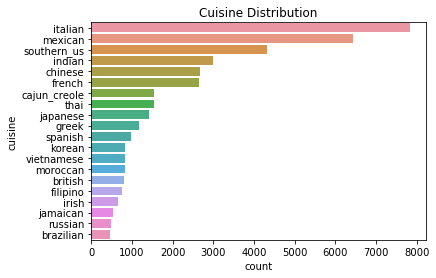

In [24]:
target = train.cuisine.copy()
sns.countplot(y=target, order=target.value_counts().reset_index()["index"])
plt.title("Cuisine Distribution")
plt.show()

Prepare text data of Train and Test ... 
Maximum Number of Ingredients in a Dish:  65
Minimum Number of Ingredients in a Dish:  1


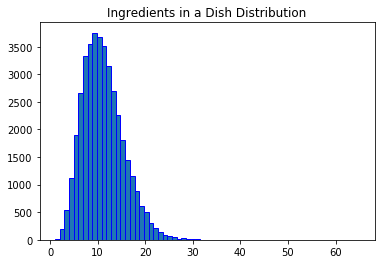

In [25]:
# Text Data Features
print ("Prepare text data of Train and Test ... ")

# drop unrelated symbol
for _, x in train.iterrows():
    for ingredient in x.ingredients:
        ingredient = ingredient.replace(',', '')
for _, x in test.iterrows():
    for ingredient in x.ingredients:
        ingredient = ingredient.replace(',', '')

print('Maximum Number of Ingredients in a Dish: ',train['ingredients'].str.len().max())
print('Minimum Number of Ingredients in a Dish: ',train['ingredients'].str.len().min())

plt.hist(train['ingredients'].str.len(),bins=max(train['ingredients'].str.len()),edgecolor='b')
#plt.gcf().set_size_inches(16,8)
plt.title('Ingredients in a Dish Distribution')
plt.show()

Deal with parent-children structure & use PCA Method

Parent-child on text data ... 
TF-IDF on text data ... 


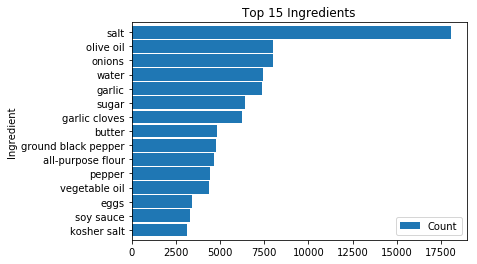

In [29]:
# Deal with parent-children structure
print ("Parent-child on text data ... ")
def getChildren(feature_name):
    Children=[]
    for i in feature_name:
        if ' ' not in i:
            if i != '' and i != ' ':
                Children.append(i)
    return Children
def UpdateVector1(data, feature_name):
    children=getChildren(feature_name)
    #print(len(children))
    column=feature_name
    deletion=[]
    for i in children:
        #print(children.index(i))
        for j in column:
            if i!=j and i in j:
                data[:,feature_name.index(i)]=data[:,feature_name.index(i)] + data[:,feature_name.index(j)]
                for idx in range(data[:,feature_name.index(i)].shape[1]):
                    if data[idx,feature_name.index(i)]>1:
                        data[idx,feature_name.index(i)]=1
                deletion.append(feature_name.index(j))
    deletion.sort(reverse = True)
    data = data.todense()
    data = np.delete(data,deletion,axis = 1)
    return data

# Feature Engineering 
print ("TF-IDF on text data ... ")
vect= CountVectorizer(max_features = 3000,tokenizer=lambda x: [i.strip() for i in x.split(',')], lowercase=False)
transformer = TfidfTransformer()
x = vect.fit_transform(train['ingredients'].apply(','.join))
x_test = vect.transform(test['ingredients'].apply(','.join)) 
#temp = UpdateVector1(x.copy(),vect.get_feature_names())
#pca1 = PCA(n_components=2)
#pca1.fit(temp)
#X = pca1.transform(temp)
X = transformer.fit_transform(x.copy())

count=dict(zip(vect.get_feature_names(), x.sum(axis=0).tolist()[0]))
count=pd.DataFrame(list(count.items()),columns=['Ingredient','Count'])
count.set_index('Ingredient').sort_values('Count',ascending=False)[:15].plot.barh(width=0.9)
plt.gca().invert_yaxis()
plt.title('Top 15 Ingredients')
plt.show()

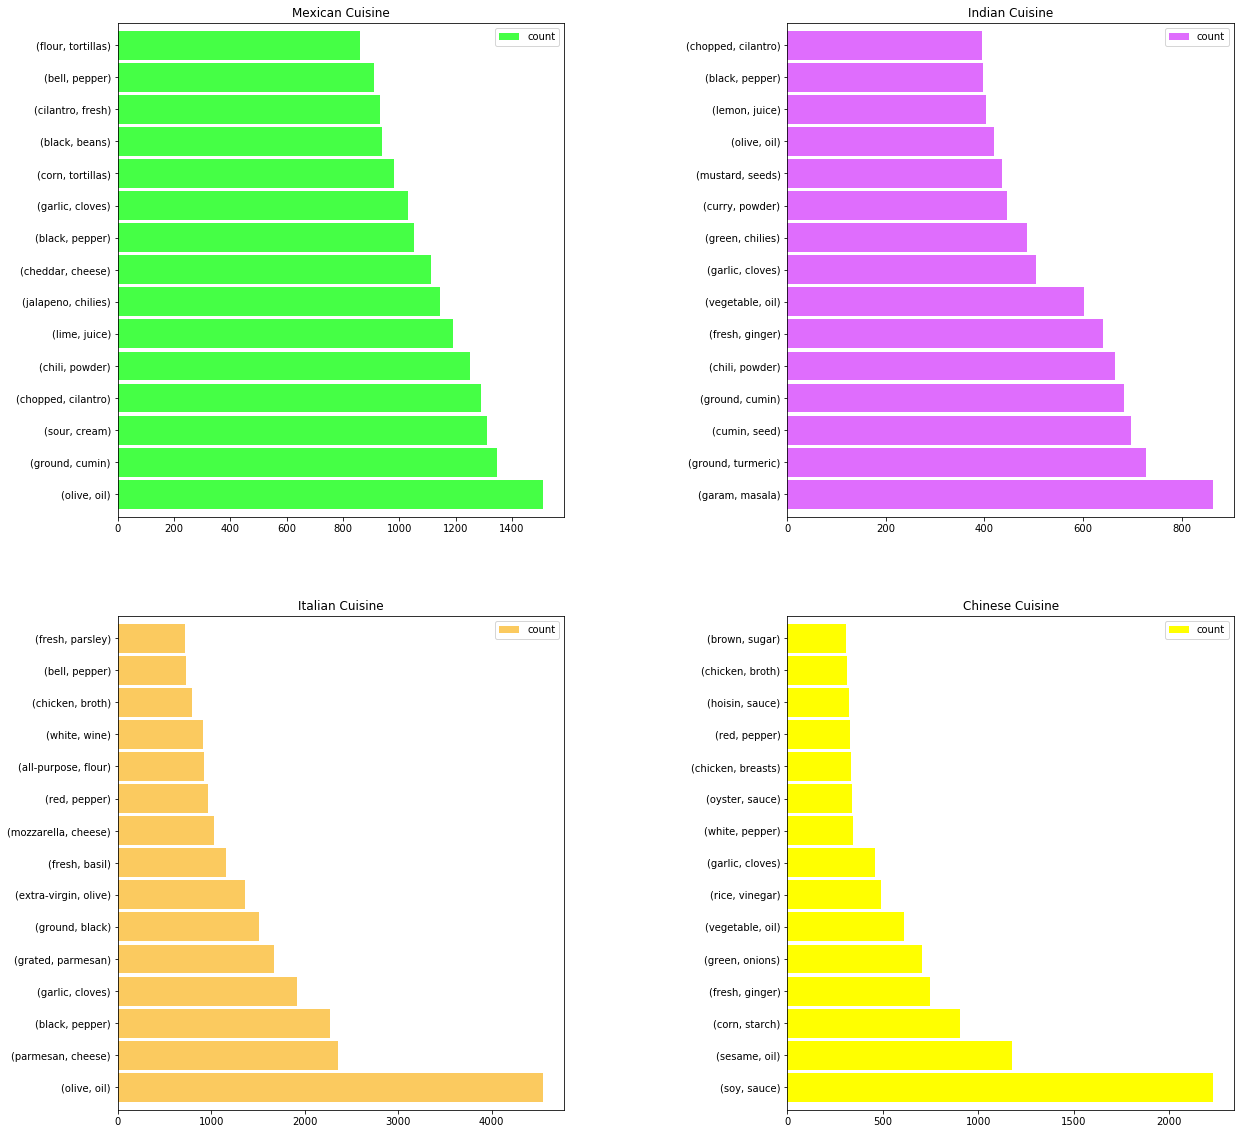

In [6]:
import nltk
from collections import Counter

train_df = pd.read_json('train.json')
train_df['seperated_ingredients'] = train_df['ingredients'].apply(','.join)
train_df['for ngrams']=train_df['seperated_ingredients'].str.replace(',',' ')
f,ax=plt.subplots(2,2,figsize=(20,20))
def ingre_cusine(cuisine):
    frame=train_df[train_df['cuisine']==cuisine]
    common=list(nltk.bigrams(nltk.word_tokenize(" ".join(frame['for ngrams']))))
    return pd.DataFrame(Counter(common),index=['count']).T.sort_values('count',ascending=False)[:15]
ingre_cusine('mexican').plot.barh(ax=ax[0,0],width=0.9,color='#45ff45')
ax[0,0].set_title('Mexican Cuisine')
ingre_cusine('indian').plot.barh(ax=ax[0,1],width=0.9,color='#df6dfd')
ax[0,1].set_title('Indian Cuisine')
ingre_cusine('italian').plot.barh(ax=ax[1,0],width=0.9,color='#fbca5f')
ax[1,0].set_title('Italian Cuisine')
ingre_cusine('chinese').plot.barh(ax=ax[1,1],width=0.9,color='#ffff00')
ax[1,1].set_title('Chinese Cuisine')
plt.subplots_adjust(wspace=0.5)
plt.show()

Train on SVM

In [8]:
'''
test = vect.fit_transform(test['ingredients'].apply(','.join)) 
temp2 = UpdateVector1(test.copy(),vect.get_feature_names())
pca2 = PCA(n_components=2)
pca2.fit(temp2)
x_test = pca2.transform(temp2)
x_test = transformer.fit_transform(x_test)  
'''
#pca1 = PCA(n_components=2)
#pca1.fit(X)
#X = pca1.transform(X)
#X_test = tfidf_features(test_text, flag="test")

# Label Encoding - Target 
print ("Label Encode the Target Variable ... ")
lb = LabelEncoder()
y = lb.fit_transform(target)

#8-2 train: validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training 
print ("Train the SVM model ... ")
classifier = SVC(C=100, # penalty parameter
	 			 kernel='rbf', # kernel type, rbf working fine here
	 			 degree=3, # default value
	 			 gamma=1, # kernel coefficient
	 			 coef0=1, # change to 1 from default value of 0.0
	 			 shrinking=True, # using shrinking heuristics
	 			 tol=0.001, # stopping criterion tolerance 
	      		 probability=False, # no need to enable probability estimates
	      		 cache_size=200, # 200 MB cache size
	      		 class_weight=None, # all classes are treated equally 
	      		 verbose=False, # print the logs 
	      		 max_iter=-1, # no limit, let it run
          		 decision_function_shape=None, # will use one vs rest explicitly 
          		 random_state=None)
model = OneVsRestClassifier(classifier, n_jobs=1)
#n_jobs:训练和预测的任务数量.如果你打算使用所有处理器,将其设置为-1.

# Train model
model.fit(X_train,y_train)

# Predictions 
print ("Predict on test data ... ")
y_predict = model.predict(X_test)

#y_pred = lb.inverse_transform(y_test)

def get_confusion_matrix(labels,scores,threshold):

        tp, fp, fn, tn = 0., 0., 0., 0.
        for i in range(len(labels)):
            if labels[i] == 1 and scores[i] >= threshold:
                tp += 1
            elif labels[i] == 0 and scores[i] >= threshold:
                fp += 1
            elif labels[i] == 1 and scores[i] < threshold:
                fn += 1
            else:
                tn += 1
        return tp,fp,fn,tn

TP,FP,FN,TN = get_confusion_matrix(y_test, y_predict,0.5)
acc = (TP + TN) / (TP + FN + FP + TN)
pre = TP / (TP + FP)
rec = TP / (TP + FN)
print('SVM: accuracy: %.2f' % acc)
print('SVM: precision: %.2f' % pre)
print('SVM: recall: %.2f' % rec)

Label Encode the Target Variable ... 
Train the SVM model ... 
Predict on test data ... 
SVM: accuracy: 1.00
SVM: precision: 0.84
SVM: recall: 1.00


Train on Logistic Regression

In [9]:
y = train.cuisine.copy()
split = int(0.8 * x.shape[0])  # Use 80% of the data for training and 20% for validation.
X_train, y_train, X_valid, y_valid = x[:split], y[:split], x[split:], y[split:]
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(penalty='l2', C = 1.2)
model.fit(X_train, y_train)
train_preds = model.predict(X_train)
valid_preds = model.predict(X_valid)
print(f'Logistic Regression: training accuracy: {accuracy_score(y_train, train_preds)}')
print(f'Logistic Regression: precision: {accuracy_score(y_valid, valid_preds)}')
preds = model.predict(x)
#print(f'Training classification accuracy: {accuracy_score(y, preds)}')

Logistic Regression: accuracy: 0.8792859612181401
Logistic Regression: precision: 0.7855436832181019


Train on Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 500)
model = model.fit(X_train,y_train)

from sklearn.metrics import accuracy_score
train_preds = model.predict(X_train)
valid_preds = model.predict(X_valid)

print(f'Random Forest: training accuracy: {accuracy_score(y_train, train_preds)}')
print(f'Random Forest: precision: {accuracy_score(y_valid, valid_preds)}')

Random Forest: accuracy: 0.9996857223671392
Random Forest: precision: 0.7255813953488373


Train on Decision Tree

In [13]:
from sklearn import tree
model2 = tree.DecisionTreeClassifier()
model2 = model.fit(X_train,y_train)

from sklearn.metrics import accuracy_score
train_preds = model2.predict(X_train)
valid_preds = model2.predict(X_valid)

print(f'Decision Tree: training accuracy: {accuracy_score(y_train, train_preds)}')
print(f'Decision Tree: precision: {accuracy_score(y_valid, valid_preds)}')

Decision Tree: accuracy: 0.9996857223671392
Decision Tree: precision: 0.7226901319924576


Train on KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier 
model3=KNeighborsClassifier(n_neighbors=7)
model3 = model3.fit(X_train,y_train)

from sklearn.metrics import accuracy_score
train_preds = model3.predict(X_train)
valid_preds = model3.predict(X_valid)

print(f'KNN: training accuracy: {accuracy_score(y_train, train_preds)}')
print(f'KNN: precision: {accuracy_score(y_valid, valid_preds)}')

KNN: accuracy: 0.6366322008862629
KNN: precision: 0.5125078566939032
